# Plot 2Dpxy maps with basin bar chart

Load libraries

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import gsw
import time

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm # beautiful colour maps
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from palettable import scientific
from palettable import cartocolors
from palettable.scientific.sequential import Batlow_20
from palettable.scientific.sequential import Devon_5_r
from palettable.scientific.sequential import Devon_10_r
from palettable.scientific.diverging import Vik_13

from dask.distributed import Client
import memory_profiler

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
from pathlib import Path
# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] )
if module_path not in sys.path:
    sys.path.append(module_path)
import custom_functions as cf

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43995/status,
Dashboard: /proxy/43995/status,Workers: 6
Total threads: 18,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43025,Workers: 6
Dashboard: /proxy/43995/status,Total threads: 18
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:40381,Total threads: 3
Dashboard: /proxy/40923/status,Memory: 33.33 GiB
Nanny: tcp://127.0.0.1:37909,


Load data, define functions

In [4]:
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht[:1000,:] 
hu = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').hu[:509,:] 
land_mask = (hu*0).fillna(1)
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
hu_shelf, shelf_mask = cf.shelf_mask_isobath(hu)

land_mask_masked = land_mask.where(land_mask == 1)
land_mask_contour = land_mask.copy(deep=True)
# remove islands
land_mask_contour[300:, 800:1000] = 0
land_mask_contour[355:,5:140] = 0
land_mask_contour[225:, 1800:2000] = 0
land_mask_contour[281:286, 2100:2128] = 0
land_mask_contour[335:348, 2123:2128] = 0
land_mask_contour[345:360, 2123:2138] = 0
land_mask_contour[360:368, 2143:2152] = 0
land_mask_contour[367:371, 2148:2158] = 0
land_mask_contour[360:380, 2130:2150] = 0
land_mask_contour[356:380, 2130:2145] = 0 
land_mask_contour[392:415, 2171:2182] = 0 
land_mask_contour[160:, 1700:1760] = 0
land_mask_contour[250:300, 2000:2065] = 0
land_mask_contour[382:400, 2150:2167] = 0 
land_mask_contour[385:400, 2167:2169] = 0
land_mask_contour[387:400, 2169:2172] = 0 
land_mask_contour[388:408, 2215:2260] = 0
land_mask_contour[405:411, 2218:2260] = 0
land_mask[300:, 800:1000] = 0
land_mask[355:,5:140] = 0
land_mask[225:, 1800:2000] = 0

Ncontour = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/input/proj01/sea_level_contour_ryf9091_N_cutoff.nc')
basin_mask = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/Antarctic_shelf_basin_mask_hu_coarse.nc')
basin_mask['basins'] = basin_mask.basins.where(basin_mask.basins != 100, np.nan)
plotmask01 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_02_EA01.nc')
plotmask02 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_03_EA02.nc')
plotmask03 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_04_Ross.nc')
plotmask04 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_05_WA.nc')
plotmask05 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_06_WAP.nc')
plotmask06 = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/plotting_mask_07_Weddell.nc')

Create colormap. 

In [5]:
# create discrete colormap
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return plt.cm.colors.ListedColormap(color_list, color_list, N)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmapB = truncate_colormap(cm.cm.dense, 0.1, 1)
cmapB = discrete_cmap(20, base_cmap=cmapB)
cmapB.set_under('w') 
cmapB.set_over('k')

Load data for plotting. 

In [6]:
# Load 2Dpxy data
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dpxy/'
#files = sorted(glob(datadir+'2Dpxy_basin_*.nc')) 
files = sorted(glob(datadir+'2Dpxy_basin_*_0.5x0.25.nc')) 

# read in bar chart data
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dpxy/'
outfile = outdir + 'BarChartData_coarse_basins.nc'
data = xr.open_dataset(outfile)

# Open Antarctic basins file
antarctic_basins = xr.open_dataset('/g/data/e14/hd4873/runs/parcels/output/AntConn/data/basin_masks/Antarctic_shelf_basin_mask_hu_coarse.nc')

# Figure 4. 

Figure parameters. 

In [7]:
colors = ['k', 'k', 'k', 'k', 'k']
regions = ['EA-W', 'EA-E', 'RS', 'WA', 'WAP', 'WS']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)']
subplot_labels = ['a)', 'b)', 'c)','d)', 'e)']
col_contour = 'blueviolet'#
maskc = 'blueviolet'#
basincol = 'r'
basinalph = 0.6
alph = 0.3
minpct = 0.0025
maxpct = 0.15
lw = 1.5
subplot_labels = ['a) East Antarctica W', 'b) East Antarctica E', 'c) Ross Sea','d) West Antarctica', 'e) Weddell Sea']

Define figure functions. 

In [8]:
def mercator_plot(axes, extent, xticks, yticks):
    '''
    Return Antarctic Mercator plot on axes
    '''   
    axes.set_extent(extent, crs=ccrs.PlateCarree())
    axes.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], 
                 colors='dimgrey', linewidths=1.4, zorder=3, alpha = 0.9, transform = ccrs.PlateCarree())
    axes.contourf(xu_ocean, yu_ocean, land_mask_masked.values, [0,1], zorder=1,
                 colors='lightgrey', alpha=1, linewidths=1.2, transform = ccrs.PlateCarree())
    axes.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=1,
                 colors='dimgrey', alpha=1, linewidths=0.5, transform = ccrs.PlateCarree())
    axes.set_xticks(xticks, crs=ccrs.PlateCarree())
    axes.set_yticks(yticks, crs=ccrs.PlateCarree())
    axes.xaxis.set_major_formatter(LongitudeFormatter())
    axes.yaxis.set_major_formatter(LatitudeFormatter())
    axes.tick_params(axis='x',labelsize=11)
    axes.tick_params(axis='y',labelsize=11)

def add_region_labels(ax1, ax3, ax5, ax7, ax9):
    ax1.text(0.01, 0.9, 'Weddell Sea', fontsize=14, transform=ax1.transAxes)
    ax3.text(0.01, 0.9, 'West Antarctica', fontsize=14, transform=ax3.transAxes)
    ax5.text(0.01, 0.9, 'Ross Sea', fontsize=14, transform=ax5.transAxes)
    ax7.text(0.01, 0.9, 'East Antarctica - East', fontsize=14, transform=ax7.transAxes)
    ax9.text(0.72, 0.9, 'East Antarctica - West', fontsize=14, transform=ax9.transAxes)
    return

def add_subplot_labels(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10):
    ax1.text(-0.09, 0.9, labels[0], fontweight='bold', fontsize=16, transform=ax1.transAxes)
    ax2.text(-0.22, 0.9, labels[5], fontweight='bold', fontsize=16, transform=ax2.transAxes)
    ax3.text(-0.09, 0.9, labels[1], fontweight='bold', fontsize=16, transform=ax3.transAxes)
    ax4.text(-0.22, 0.9, labels[6], fontweight='bold', fontsize=16, transform=ax4.transAxes)
    ax5.text(-0.09, 0.9, labels[2], fontweight='bold', fontsize=16, transform=ax5.transAxes)
    ax6.text(-0.22, 0.9, labels[7], fontweight='bold', fontsize=16, transform=ax6.transAxes)
    ax7.text(-0.09, 0.9, labels[3], fontweight='bold', fontsize=16, transform=ax7.transAxes)
    ax8.text(-0.22, 0.9, labels[8], fontweight='bold', fontsize=16, transform=ax8.transAxes)
    ax9.text(-0.09, 0.9, labels[4], fontweight='bold', fontsize=16, transform=ax9.transAxes)
    ax10.text(-0.22, 0.9, labels[9], fontweight='bold', fontsize=16, transform=ax10.transAxes)
    return

def contour_release_sector(ax1, ax3, ax5, ax7, ax9):
    ax1.contour(xu_ocean[2180:2700], yu_ocean[:395], land_mask_contour[:395,2180:2700].values, [0,1], zorder=1,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax1.contour(xu_ocean[2203:2300], yu_ocean[394:408], land_mask_contour[394:408,2203:2300].values, [0,1], zorder=1,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax1.contour(xu_ocean[2214:2300], yu_ocean[408:418], land_mask_contour[408:418,2214:2300].values, [0,1], zorder=1,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax1.contour(xu_ocean[2235:2300], yu_ocean[418:426], land_mask[418:426,2235:2300].values, [0,1], zorder=1,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax3.contour(xu_ocean[1431:2179], yu_ocean[:400], land_mask_contour[:400,1431:2179].values, [0,1], zorder=1,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax5.contour(xu_ocean[820:1430], yu_ocean[:223], land_mask[:223,820:1430].values, [0,1], zorder=1,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax7.contour(xu_ocean[140:920], yu_ocean[225:], land_mask[225:,140:920].values, [0,1], zorder=1,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax9.contour(xu_ocean[2700:], yu_ocean, land_mask[:,2700:].values, [0,1], zorder=1,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    ax9.contour(xu_ocean[0:140], yu_ocean, land_mask[:,0:140].values, [0,1], zorder=1,
                colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    
def plot_barchart_pct_labels(ax2, ax4, ax6, ax8, ax10):
    if weight == 1:
        # plt histogram percentages
        ax2.text(0.0826, 0.042, '1%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.216, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.374, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.548, 0.08, '5%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.6908, 0.62, '63%', fontweight='normal', fontsize=11, transform=ax2.transAxes)

        ax4.text(0.066, 0.14, '13%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.216, 0.33, '33%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.376, 0.676, '68%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.694, 0.13, '12%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.867, 0.06, '4%', fontweight='normal', fontsize=11, transform=ax4.transAxes)

        ax6.text(0.066, 0.13, '11%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.218, 0.37, '37%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.532, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.702, 0.06, '3%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.866, 0.06, '4%', fontweight='normal', fontsize=11, transform=ax6.transAxes)

        ax8.text(0.06, 0.63, '64%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.373, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.53, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.69, 0.18, '17%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.842, 0.21, '20%', fontweight='normal', fontsize=11, transform=ax8.transAxes)

        ax10.text(0.22, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.375, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.546, 0.05, '2%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.693, 0.43, '43%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.849, 0.54, '54%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
    else:
        ax2.text(0.0826, 0.042, '2%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.218, 0.03, ' 1%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.376, 0.03, ' 1%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.548, 0.1, '8%', fontweight='normal', fontsize=11, transform=ax2.transAxes)
        ax2.text(0.6908, 0.66, '67%', fontweight='normal', fontsize=11, transform=ax2.transAxes)

        ax4.text(0.066, 0.14, '13%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.216, 0.33, '33%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.376, 0.676, '69%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.697, 0.145, '14%', fontweight='normal', fontsize=11, transform=ax4.transAxes)
        ax4.text(0.867, 0.06, '4%', fontweight='normal', fontsize=11, transform=ax4.transAxes)

        ax6.text(0.066, 0.162, '15%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.218, 0.467, '46%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.532, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.702, 0.06, '4%', fontweight='normal', fontsize=11, transform=ax6.transAxes)
        ax6.text(0.866, 0.06, '5%', fontweight='normal', fontsize=11, transform=ax6.transAxes)

        ax8.text(0.06, 0.68, '69%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.373, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.53, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.69, 0.198, '19%', fontweight='normal', fontsize=11, transform=ax8.transAxes)
        ax8.text(0.842, 0.228, '22%', fontweight='normal', fontsize=11, transform=ax8.transAxes)

        ax10.text(0.22, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.375, 0.03, '<1%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.546, 0.05, '2%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.693, 0.432, '44%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
        ax10.text(0.849, 0.556, '57%', fontweight='normal', fontsize=11, transform=ax10.transAxes)
    return

def plot_releasesector_label(ax2, ax4, ax6, ax8, ax10):
    ax2.text(0.875, 0.2, 'Release sector', fontweight='normal', fontsize=14, transform=ax2.transAxes, rotation=90)
    ax4.text(0.56, 0.2, 'Release sector', fontweight='normal', fontsize=14, transform=ax4.transAxes, rotation=90)
    ax6.text(0.406, 0.2, 'Release sector', fontweight='normal', fontsize=14, transform=ax6.transAxes, rotation=90)
    ax8.text(0.247, 0.2, 'Release sector', fontweight='normal', fontsize=14, transform=ax8.transAxes, rotation=90)
    ax10.text(0.088, 0.2, 'Release sector', fontweight='normal', fontsize=14, transform=ax10.transAxes, rotation=90)
    return

def plot_axis_ticks_labels(ax2, ax4, ax6, ax8, ax10):
    ax2.set_ylabel('Connectivity (%)', fontsize=13)
    ax4.set_ylabel('Connectivity (%)', fontsize=13)
    ax6.set_ylabel('Connectivity (%)', fontsize=13)
    ax8.set_ylabel('Connectivity (%)', fontsize=13)
    ax10.set_ylabel('Connectivity (%)', fontsize=13)
    ax2.tick_params(axis='y',labelsize=13)
    ax2.set_xticks([])
    ax2.grid(c='gainsboro')
    ax4.tick_params(axis='y',labelsize=13)
    ax4.set_xticks([])
    ax4.grid(c='gainsboro')
    ax6.tick_params(axis='y',labelsize=13)
    ax6.set_xticks([])
    ax6.grid(c='gainsboro')
    ax8.tick_params(axis='y',labelsize=13)
    ax8.set_xticks([])
    ax8.grid(c='gainsboro')
    ax10.tick_params(axis='y',labelsize=13)
    ax10.grid(axis='y', c='gainsboro')
    ax10.tick_params(axis='x',labelsize=13)
    #ax10.set_xticklabels(labels = regions, rotation=90, ha='center', va='top')
    ax10.set_xticklabels(labels = ['\nEast Antarctica\n-West','\nEast Antarctica\n-East', 'Ross Sea',
                                   'West \nAntarctica','Antarctica\nPeninsula','Weddell \nSea'], 
                         rotation=90, ha='center', va='top')  


def plot_barchart_arrows(ax2, ax4, ax6, ax8, ax10):
    ax2.annotate('',xy=(0.4, 0.9), xytext=(0.8, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05),
                 horizontalalignment='right', verticalalignment='top')
    ax4.annotate('',xy=(0.1, 0.9), xytext=(0.5, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05),
                 horizontalalignment='right', verticalalignment='top')
    ax4.annotate('',xy=(0.78, 0.9), xytext=(0.65, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05),
                 horizontalalignment='right', verticalalignment='top')
    ax6.annotate('',xy=(0.1, 0.9), xytext=(0.34, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05,),
                 horizontalalignment='right', verticalalignment='top')
    ax6.annotate('',xy=(0.87, 0.9), xytext=(1.005, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05),
                 horizontalalignment='right', verticalalignment='top')
    ax8.annotate('',xy=(0.07, 0.9), xytext=(0.17, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05,),
                 horizontalalignment='right', verticalalignment='top')
    ax8.annotate('',xy=(0.75, 0.9), xytext=(1.01, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05,),
                 horizontalalignment='right', verticalalignment='top')
    ax10.annotate('',xy=(0.0, 0.9), xytext=(0.04, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', headlength=0,width=4),
                 horizontalalignment='right', verticalalignment='top')
    ax10.annotate('',xy=(0.6, 0.9), xytext=(1.02, 0.9),
                 xycoords="axes fraction", textcoords="axes fraction",
                 arrowprops=dict(facecolor='crimson', ec='crimson', shrink=0.05,),
                 horizontalalignment='right', verticalalignment='top')
    return

def plot_bars(ax, data, n):
    if weight == 1:
        barlist = ax.bar(data.source_region, data.basin_trans_pct[n,:], color=colors, alpha=0.9, zorder=2)
        barlist[n].set_color('none')
        ax.bar(data.source_region[n], data.basin_trans_pct[n,n], edgecolor='k', color='w', zorder=2)
    else:
        barlist = ax.bar(data.source_region, data.basin_count[n,:]/data.basin_count[n,:].max()*100, 
                         color=colors, alpha=0.9, zorder=2)
        barlist[n].set_color('none')
        ax.bar(data.source_region[n], data.basin_count[n,n]/data.basin_count[n,:].max()*100, 
               edgecolor='k', color='w', zorder=2)
    
def plot_pxy(ax, ds):
    if weight == 1:
        pxy = ds.pxy_trans_pct
    else: 
        pxy = ds.pxy_pct
    pxy = pxy.where(pxy>=minpct, np.nan)
    pxy = pxy/100.
    p1 = ax.pcolormesh(ds.lon, ds.lat, pxy.T, cmap = cmapB, vmin=minpct, vmax=maxpct, zorder=0,transform=ccrs.PlateCarree())
    return p1

def add_colorbar(shading):
    # Add a colorbar axis at bottom of figure
    cbar_ax = fig.add_axes([0.179, 0.1, 0.473, 0.015])
    # Draw the colorbar
    cbar=fig.colorbar(shading, cax=cbar_ax,orientation='horizontal', extend='both')
    cbar.set_ticks([minpct, 0.05, .1, .15])#, rotation=270)
    cbar.set_ticklabels([minpct, .05, .10, .15])#, rotation=270)
    cbar.ax.tick_params(labelsize=14)
    return cbar

def figure():
    fig = plt.figure(constrained_layout=True, figsize=(18,18))
    spec1 = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)
    ax1 = fig.add_subplot(spec1[0, 0:3], projection=ccrs.Mercator(central_longitude=-40))
    ax2 = fig.add_subplot(spec1[0, 3], )
    ax3 = fig.add_subplot(spec1[1,0:3], projection=ccrs.Mercator(central_longitude=-100))
    ax4 = fig.add_subplot(spec1[1,3], )
    ax5 = fig.add_subplot(spec1[2,0:3], projection=ccrs.Mercator(central_longitude=180))
    ax6 = fig.add_subplot(spec1[2,3], )
    ax7 = fig.add_subplot(spec1[3,0:3], projection=ccrs.Mercator(central_longitude=120))
    ax8 = fig.add_subplot(spec1[3,3], )
    ax9 = fig.add_subplot(spec1[4,0:3], projection=ccrs.Mercator(central_longitude=90))
    ax10= fig.add_subplot(spec1[4,3], )
    fig.subplots_adjust(wspace=0, hspace=0.06)
    
    ## Map columns
    # Subplot a) ---------------------------------------------------------------------
    xticks = [-100, -70, -40, -10, 20, 50]
    yticks = [-78, -74, -70, -66, -62,]
    mercator_plot(ax1, [-110, 70, -78, -59.5], xticks, yticks)
    ax1.tick_params(axis="x",direction="in", pad=-20)
    # Subplot b) ---------------------------------------------------------------------
    xticks = [-230, -200, -170, -140, -110, -80]
    yticks = [-78, -74, -70, -66, -62] 
    mercator_plot(ax3, [-239, -59, -78.2, -60], xticks, yticks)
    ax3.tick_params(axis="x",direction="in", pad=-20)
    # Subplot c) ---------------------------------------------------------------------
    xticks = [70, 100, 130, 160, 190, 220,]
    yticks = [-78, -74, -70, -66, -62]
    mercator_plot(ax5, [60, 240, -78.5, -60.6], xticks, yticks)
    ax5.tick_params(axis="x",direction="in", pad=-20)
    # Subplot d) ---------------------------------------------------------------------
    xticks = [10, 40, 70, 100, 130, 160, ]
    yticks = [-76, -72, -68, -64, -60, -56] 
    yticks = [-72, -68, -64, -60, -56] 
    mercator_plot(ax7, [-5, 175, -76.1, -54.6], xticks, yticks)
    ax7.tick_params(axis="x",direction="in", pad=-20)
    # Subplot e) ---------------------------------------------------------------------
    xticks = [-60, -30, 0, 30, 60, 90]
    yticks = [-78, -74, -70, -66, -62, ]
    mercator_plot(ax9, [-80, 100, -78, -59.2], xticks, yticks)
    ax9.tick_params(axis="x",direction="in", pad=-20)
    
    # contour release sectors
    contour_release_sector(ax1, ax3, ax5, ax7, ax9)
    # add release sector legend
    release_line = Line2D([0], [0], color=basincol, alpha=0.8, lw=lw)
    ax1.legend([release_line], ['Release sector'], loc='lower right', fontsize=14, bbox_to_anchor=[0.95, 0.2], framealpha=0.5, fancybox=True)
    
    add_region_labels(ax1, ax3, ax5, ax7, ax9)
    
    ## Bar chart columns
    plot_barchart_pct_labels(ax2, ax4, ax6, ax8, ax10)
    plot_barchart_arrows(ax2, ax4, ax6, ax8, ax10)
    plot_releasesector_label(ax2, ax4, ax6, ax8, ax10)
    plot_axis_ticks_labels(ax2, ax4, ax6, ax8, ax10)
    
    ## General
    add_subplot_labels(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10)
    
    return fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10)

Plot figure.

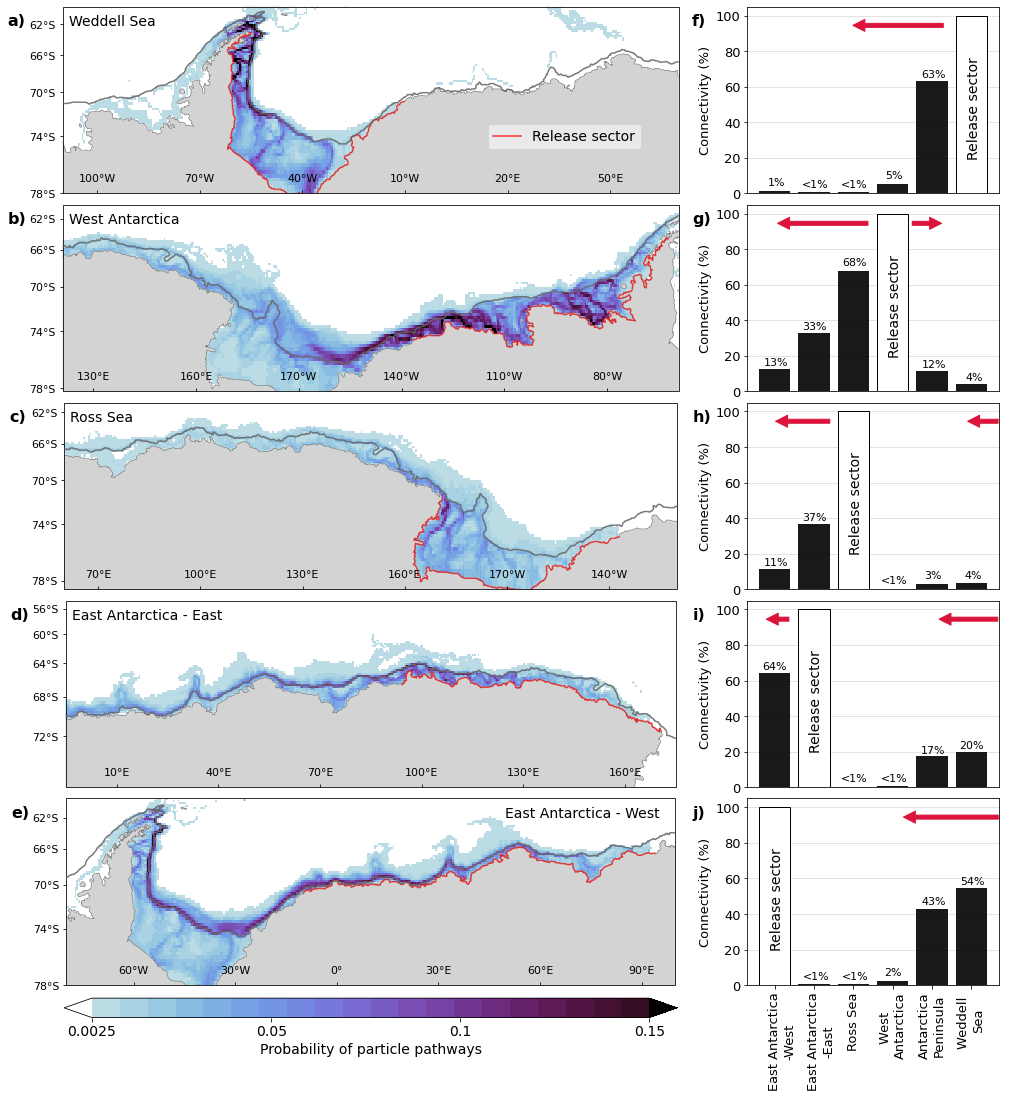

In [9]:
weight = 1  # weighting boolean to indicate transport weighting (or not)
            # 1 = particle count weighted by transport value to account for differing size of grid cells
            # 0 = simple particle count

fig,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10) = figure()

## Read in and plot data
# Subplot a) & f)----------------------------------------------------------------  
n = 5
ds = xr.open_dataset(files[n])
plot_pxy(ax1, ds)
plot_bars(ax2, data, n)

# Subplot b) & g)----------------------------------------------------------------  
n = 3
ds = xr.open_dataset(files[n])
plot_pxy(ax3, ds)
plot_bars(ax4, data, n)

# Subplot c) & h)----------------------------------------------------------------  
n = 2
ds = xr.open_dataset(files[n])
plot_pxy(ax5, ds)
plot_bars(ax6, data, n)

# Subplot d) & i)----------------------------------------------------------------  
n = 1
ds = xr.open_dataset(files[n])
plot_pxy(ax7, ds)
plot_bars(ax8, data, n)
    
# Subplot e) & j)---------------------------------------------------------------- 
n = 0
ds = xr.open_dataset(files[n])
p1 = plot_pxy(ax9, ds)
plot_bars(ax10, data, n)

cbar = add_colorbar(p1)
if weight == 1:
    cbar.set_label('Probability of particle pathways', fontsize=14)#, rotation=270)
else:
    cbar.set_label('Particles (%)', fontsize=14)#, rotation=270)


## Save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
if weight == 1:
    outfile = outdir + 'Fig04_0.5x0.25map_transweight.jpg'
else:
    outfile = outdir + 'Fig04_0.5x0.25map_particleweight.jpg'
fig.savefig(outfile, dpi=300, bbox_inches='tight')
plt.show()

# Figure 5. 

In [10]:
def mercator_plot(axes, extent, xticks, yticks):
    '''
    Return Antarctic Mercator plot on axes
    ''' 
    axes.set_extent(extent)
    axes.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], 
                 colors='k', linewidths=1.5, zorder=3, alpha = 0.8, transform = ccrs.PlateCarree())
    axes.contourf(xu_ocean, yu_ocean, land_mask_masked.values, [0,1], zorder=1,
                 colors='lightgrey', alpha=1, linewidths=1.2, transform = ccrs.PlateCarree())
    axes.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=1,
                 colors='dimgrey', alpha=1, linewidths=0.5, transform = ccrs.PlateCarree())
    axes.set_xticks(xticks, crs=ccrs.PlateCarree())
    axes.set_yticks(yticks, crs=ccrs.PlateCarree())
    axes.xaxis.set_major_formatter(LongitudeFormatter())
    axes.yaxis.set_major_formatter(LatitudeFormatter())
    axes.tick_params(axis='x',labelsize=12)
    axes.tick_params(axis='y',labelsize=12)

In [11]:
labels = ['a)', 'b)', 'c)']
style = "Simple, tail_width=2, head_width=10, head_length=8"
kw = dict(arrowstyle=style, color='r', alpha=0.7) #"darkslategrey"

style2 = "Simple, tail_width=1, head_width=8, head_length=8"
kw2 = dict(arrowstyle=style2, color='k', alpha=1) #"darkslategrey"

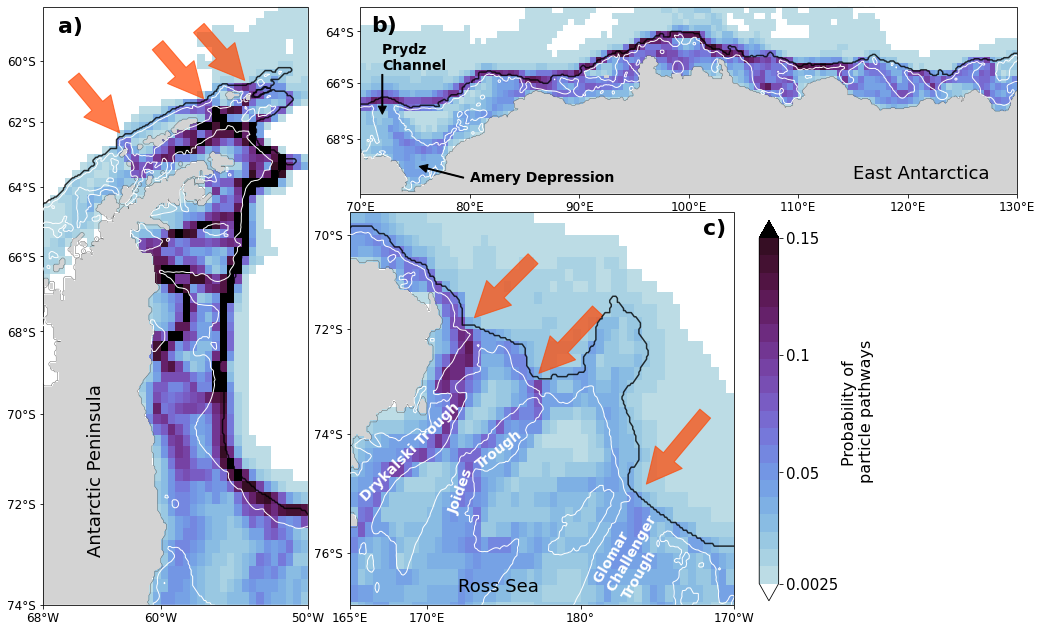

In [12]:
minpct = 0.0025
maxpct = 0.15

fig4 = plt.figure(constrained_layout=True, figsize=(18,11))
spec1 = gridspec.GridSpec(ncols=7, nrows=3, figure=fig4)
ax1 = fig4.add_subplot(spec1[0, 2:], projection=ccrs.Mercator(central_longitude=120))
#ax2 = fig2.add_subplot(spec1[1,:3], projection=ccrs.Mercator(central_longitude=-130))
ax3 = fig4.add_subplot(spec1[1:,2:5], projection=ccrs.Mercator(central_longitude=180))
ax4 = fig4.add_subplot(spec1[:,0:2], projection=ccrs.Mercator(central_longitude=-100))
fig4.subplots_adjust(wspace=0.18, hspace=0.1)

xticks = [70,80,90, 100, 110,120,130,]
yticks = [-68, -66, -64, ]
mercator_plot(ax1, [70, 120, -68, -63], xticks, yticks)
ds = xr.open_dataset(files[1])
pxy = ds.pxy_trans_pct
pxy = pxy.where(pxy>=minpct, np.nan)
pxy = pxy/100.
p1 = ax1.pcolormesh(ds.lon, ds.lat, pxy.T, cmap = cmapB, vmin=minpct, vmax=maxpct, zorder=0, transform=ccrs.PlateCarree())
ax1.contour(ht.xt_ocean, ht.yt_ocean, ht, [500], zorder=3, colors='w',linewidths=1,transform=ccrs.PlateCarree())
a2 = mpatches.FancyArrowPatch((79.6, -69.3), (75.2, -68.9),
                              connectionstyle="arc3,rad=0", zorder=4, 
                              transform=ccrs.PlateCarree(), **kw2)
a3 = mpatches.FancyArrowPatch((72, -65.6), (72, -67.2),
                              connectionstyle="arc3,rad=0", zorder=4, 
                              transform=ccrs.PlateCarree(), **kw2)
ax1.add_patch(a2)
ax1.add_patch(a3)
ax1.text(80, -69.4, 'Amery Depression', c='k', fontsize=14,fontweight='bold',transform=ccrs.PlateCarree())
ax1.text(72, -65.5, 'Prydz \nChannel', c='k', fontsize=14,fontweight='bold',transform=ccrs.PlateCarree())

# Ross Sea
xticks = [165,170,180,190]
yticks = [-76,-74,-72,-70,]
mercator_plot(ax3, [165, 190, -76.5, -69.5], xticks, yticks)
ds = xr.open_dataset(files[2])
pxy = ds.pxy_trans_pct
pxy = pxy.where(pxy>=minpct, np.nan)
pxy = pxy/100.
p1 = ax3.pcolormesh(ds.lon, ds.lat, pxy.T, cmap = cmapB, vmin=minpct, vmax=maxpct, zorder=0, transform=ccrs.PlateCarree())
ax3.contour(ht.xt_ocean, ht.yt_ocean, ht, [500], zorder=3, colors='w',linewidths=1,transform=ccrs.PlateCarree())
arrow1 = mpatches.FancyArrowPatch((177, -70.5), (173, -71.8),
                                 fc = 'orangered',
                                 ec = 'orangered',
                                 alpha=0.7,
                                 mutation_scale=70,
                                 transform=ccrs.PlateCarree())
arrow2 = mpatches.FancyArrowPatch((181.2, -71.6), (177.2, -72.9),
                                 fc = 'orangered',
                                 ec = 'orangered',
                                 alpha=0.7,
                                 mutation_scale=70,
                                 transform=ccrs.PlateCarree())
arrow3 = mpatches.FancyArrowPatch((188.2, -73.6), (184.2, -74.9),
                                 fc = 'orangered',
                                 ec = 'orangered',
                                 alpha=0.7,
                                 mutation_scale=70,
                                 transform=ccrs.PlateCarree())
ax3.add_patch(arrow1)
ax3.add_patch(arrow2)
ax3.add_patch(arrow3)
ax3.text(165.5, -75.15, 'Drykalski Trough', c='w', rotation=45,fontsize=14,fontweight ='bold',transform=ccrs.PlateCarree())
ax3.text(171.3, -75.35, 'Joides', c='w', rotation=70,fontsize=14,fontweight='bold',transform=ccrs.PlateCarree())
ax3.text(173, -74.6, 'Trough', c='w', rotation=38,fontsize=14,fontweight='bold',transform=ccrs.PlateCarree())
ax3.text(180.7, -76.7, 'Glomar \nChallenger \nTrough', c='w', rotation=60,fontsize=14,fontweight='bold',transform=ccrs.PlateCarree())

# Weddell Sea
xticks = [-68,-60,-50]
yticks = [-74,-72,-70,-68,-66,-64,-62,-60]
mercator_plot(ax4, [-68, -50, -73.6, -58.1], xticks, yticks)
ds = xr.open_dataset(files[5])
pxy = ds.pxy_trans_pct
pxy = pxy.where(pxy>=minpct, np.nan)
pxy = pxy/100.
p1 = ax4.pcolormesh(ds.lon, ds.lat, pxy.T, cmap = cmapB, vmin=minpct, vmax=maxpct, zorder=0, transform=ccrs.PlateCarree())
ax4.contour(ht.xt_ocean, ht.yt_ocean, ht, [500], zorder=3, colors='w',linewidths=1,transform=ccrs.PlateCarree())
arrow1 = mpatches.FancyArrowPatch((-66, -60.5), (-62.7, -62.4),
                                 fc = 'orangered',
                                 ec = 'orangered',
                                 alpha=0.7,
                                 mutation_scale=70,
                                 transform=ccrs.PlateCarree())
arrow2 = mpatches.FancyArrowPatch((-60.3, -59.4), (-57, -61.3),
                                 fc = 'orangered',#dimgrey
                                 ec = 'orangered',#dimgrey
                                 alpha=0.7,
                                 mutation_scale=70,
                                 transform=ccrs.PlateCarree())
arrow3 = mpatches.FancyArrowPatch((-57.5, -58.8), (-54.2, -60.7),
                                 fc = 'orangered',
                                 ec = 'orangered',
                                 alpha=0.7,
                                 mutation_scale=70,
                                 transform=ccrs.PlateCarree())
ax4.add_patch(arrow1)
ax4.add_patch(arrow2)
ax4.add_patch(arrow3)

# subplot labels
fs = 22
ax1.text(71, -64, labels[1], c='k', fontsize=fs,fontweight='bold',transform=ccrs.PlateCarree())
ax3.text(188, -70, labels[2], c='k', fontsize=fs,fontweight='bold',transform=ccrs.PlateCarree())
ax4.text(-67, -59, labels[0], c='k', fontsize=fs,fontweight='bold',transform=ccrs.PlateCarree())

# add East Antarctica and Antarctic Peninsula labels
ax1.text(115, -69.3, 'East Antarctica', c='k', fontsize=18,fontweight='normal',transform=ccrs.PlateCarree())
ax3.text(172, -76.6, 'Ross Sea', c='k', fontsize=18,fontweight='normal',transform=ccrs.PlateCarree())
ax4.text(-65, -73, 'Antarctic Peninsula', c='k', rotation=90, fontsize=18,fontweight='normal',transform=ccrs.PlateCarree())

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig4.add_axes([0.68, 0.13, 0.015, 0.48])
# Draw the colorbar
cbar=fig4.colorbar(p1, cax=cbar_ax,orientation='vertical', extend='both')
cbar.set_label('Probability of \nparticle pathways', fontsize=16)
cbar.set_ticks([minpct, 0.05, .10, .15,])
cbar.set_ticklabels([minpct, .05, .10, .15,])
cbar.ax.tick_params(labelsize=15)

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
outfile = outdir + 'Fig05_zoom_pathways.jpg'
fig4.savefig(outfile, dpi=300, bbox_inches='tight')

plt.show()

# Supporting Information Figure S7

Stereo plots with entire trajectories including component after shelf exit. 

In [13]:
# Load 2Dpxy data
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/2Dpxy/'
files = sorted(glob(datadir+'WholeTrajectory_2Dpxy_basin_*_0.5x0.25.nc')) 

In [14]:
def stereo_plot(axes, extent):
    '''
    Return Antarctic stereographic plot on axes
    '''
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axes.set_extent(extent, crs=ccrs.PlateCarree())
    axes.set_boundary(circle, transform=axes.transAxes)
    #axes.add_feature(land_50m, zorder=1, color='lightgrey')
    yu_ocean[0]=-90
    axes.contourf(xu_ocean, yu_ocean, land_mask_masked.values, [0,1], zorder=1,
                 colors='lightgrey', alpha=1, linewidths=1.2, transform = ccrs.PlateCarree())
    axes.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], 
                 colors='k', linewidths=1.5, zorder=3, transform = ccrs.PlateCarree())
    axes.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=3,
                 colors='grey', alpha=0.8, linewidths=1.2, transform = ccrs.PlateCarree())
    gl = axes.gridlines(crs=ccrs.PlateCarree(), 
                        #draw_labels=True,
                        linewidth=1, color='grey', alpha=0.7, linestyle=':')
    return

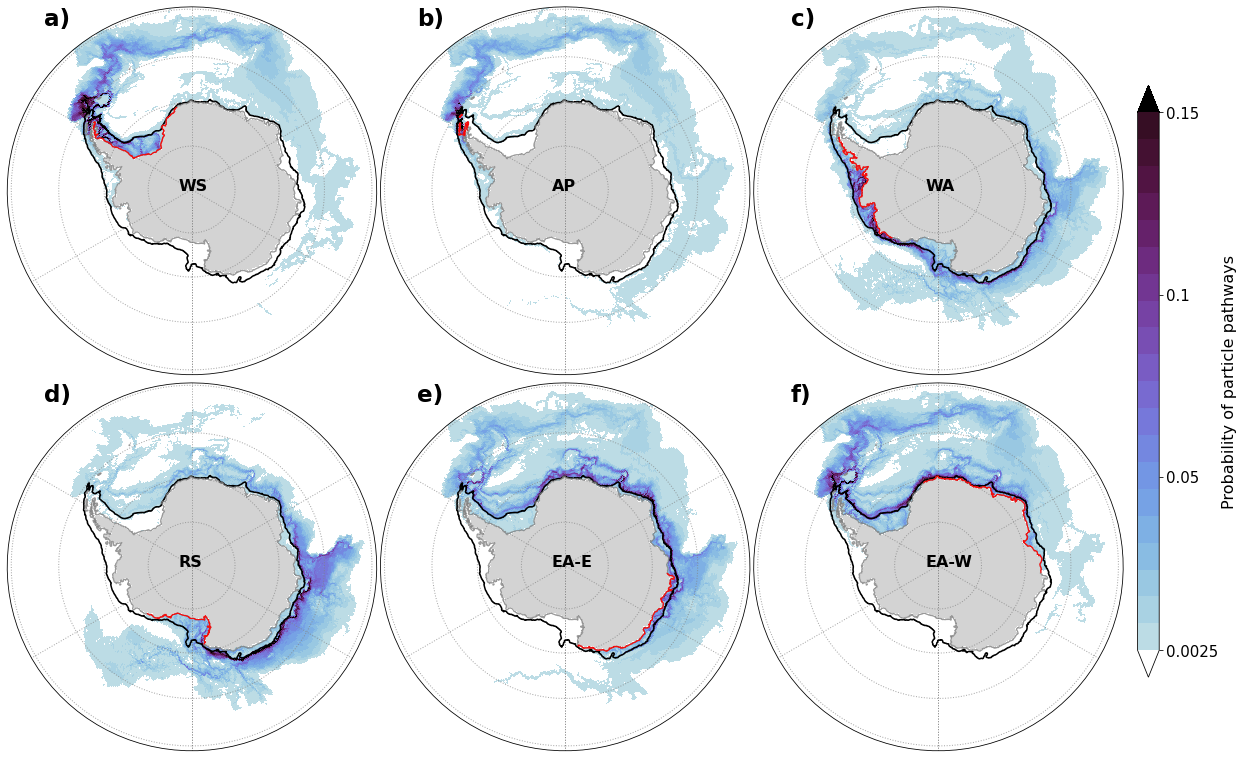

2023-01-17 14:51:16,387 - distributed.nanny - WARNING - Restarting worker
2023-01-17 14:51:16,394 - distributed.nanny - WARNING - Restarting worker
2023-01-17 14:51:16,456 - distributed.nanny - WARNING - Restarting worker
2023-01-17 14:51:16,462 - distributed.nanny - WARNING - Restarting worker
2023-01-17 14:51:16,493 - distributed.nanny - WARNING - Restarting worker
2023-01-17 14:51:16,526 - distributed.nanny - WARNING - Restarting worker
2023-01-17 14:51:16,594 - distributed.nanny - WARNING - Restarting worker
2023-01-17 14:51:16,596 - distributed.nanny - WARNING - Restarting worker
2023-01-17 14:51:16,615 - distributed.nanny - WARNING - Restarting worker
2023-01-17 14:51:16,623 - distributed.nanny - WARNING - Restarting worker
2023-01-17 14:51:16,641 - distributed.nanny - WARNING - Restarting worker
2023-01-17 14:51:16,676 - distributed.nanny - WARNING - Restarting worker
2023-01-17 14:51:16,750 - distributed.nanny - WARNING - Restarting worker
2023-01-17 14:51:16,754 - distributed.

In [15]:
# figure params
ncols = 3
nrows = 2
minpct = 0.0025
maxpct = 0.15
basincol = 'r'
basinalph = 0.9
lw = 1.2
subplot_labels = ['a)','b)','c)','d)','e)','f)']

## Define the figure and each axis for the 3 rows and 3 columns
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()},
                        figsize=(20,13.7), 
                         #figsize=(14.5,9.7), 
                         squeeze=True)
#titles = ["EA-W", "EA-E", "RS", "WA", "WAP", "WS"]
titles = ["WS","AP","WA","RS", "EA-E","EA-W"]
#Loop over all of the models
for i, ax in enumerate(axes.flatten()):
    ax.text(0.1,0.95, subplot_labels[i], fontweight='bold', fontsize=23, transform = ax.transAxes)
    stereo_plot(ax, [-280, 80, -80, -49])
    
    # Read in data
    ds = xr.open_dataset(files[-1-i])
    ds['pxy_trans_pct'] = ds.pxy_trans_pct/100.
    # plot data
    p1 = ax.pcolormesh(ds.lon, ds.lat, ds.pxy_trans_pct.T, cmap = cmapB, vmin=minpct, vmax=maxpct, transform=ccrs.PlateCarree())
    #ax.set_title("{}".format(titles[i]), fontsize=16)
    ax.text(-93,-87,"{}".format(titles[i]), fontsize=16, c='k', fontweight='bold', transform=ccrs.PlateCarree(), 
           #bbox=dict(facecolor='none', edgecolor='dimgrey', boxstyle='round,pad=0.3'),
           )
    # plot basin region as red contour
    if i == 5:
        ax.contour(xu_ocean[2700:], yu_ocean, land_mask[:,2700:].values, [0,1], zorder=3,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
        ax.contour(xu_ocean[0:140], yu_ocean, land_mask[:,0:140].values, [0,1], zorder=3,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    elif i == 4:
        ax.contour(xu_ocean[140:920], yu_ocean[225:], land_mask[225:,140:920].values, [0,1], zorder=3,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    elif i == 3:
        ax.contour(xu_ocean[820:1430], yu_ocean[:223], land_mask[:223,820:1430].values, [0,1], zorder=3,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    elif i == 2:
        ax.contour(xu_ocean[1431:2179], yu_ocean[:400], land_mask_contour[:400,1431:2179].values, [0,1], zorder=3,
        colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    elif i == 1:
        ax.contour(xu_ocean[2000:2279], yu_ocean[400:], land_mask_contour[400:,2000:2279].values, [0,1], zorder=3,
        colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
    elif i == 0:
        ax.contour(xu_ocean[2180:2700], yu_ocean[:395], land_mask_contour[:395,2180:2700].values, [0,1], zorder=3,
            colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
        ax.contour(xu_ocean[2203:2300], yu_ocean[394:408], land_mask_contour[394:408,2203:2300].values, [0,1], zorder=3,
                    colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
        ax.contour(xu_ocean[2214:2300], yu_ocean[408:418], land_mask_contour[408:418,2214:2300].values, [0,1], zorder=3,
                    colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
        ax.contour(xu_ocean[2235:2300], yu_ocean[418:426], land_mask[418:426,2235:2300].values, [0,1], zorder=3,
                    colors=basincol, alpha=basinalph, linewidths=lw, transform = ccrs.PlateCarree())
        
# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.91, 0.2, 0.015, 0.6])
# Draw the colorbar
if minpct == 0:
    cbar=fig.colorbar(p1, cax=cbar_ax,orientation='vertical', extend='max')
else:
    cbar=fig.colorbar(p1, cax=cbar_ax,orientation='vertical', extend='both')
cbar.set_label('Probability of particle pathways', fontsize=16)#, rotation=270)
cbar.set_ticks([minpct, 0.05, .10, .15,])#, rotation=270)
cbar.set_ticklabels([minpct, .05, .10, .15,])#, rotation=270)
cbar.ax.tick_params(labelsize=15)

fig.subplots_adjust(hspace=0.02, wspace=0.01)

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
outfile = outdir + 'FigS3_stereo_0.5x0.25map_whole_trajectories.jpg'
fig.savefig(outfile, dpi=300, bbox_inches='tight')